In [95]:
import numpy as np
import matplotlib.pyplot as plt
import pymc3 as pm
from sklearn.cluster import KMeans

### Stationary GP
def kernel(a, b, lenghtscale, std):
    """
    Borrowed from Nando De Freita's lecture code
    https://www.cs.ubc.ca/~nando/540-2013/lectures/gp.py
    """
    sqdist = np.sum(a**2,1).reshape(-1,1) + np.sum(b**2,1) - 2*np.dot(a, b.T)
    return std**2*np.exp(-.5 * (1/lenghtscale) * sqdist)

### LLS GP
def global_kernel(x1, x2, l1, l2, std):
    sqdist = np.sum(x1**2,1).reshape(-1,1) + np.sum(x2**2,1) - 2*np.dot(x1, x2.T)
    l1l2meansqr = (np.square(l1)[:, np.newaxis, :] + np.square(l2)[np.newaxis, :, :]).squeeze()/2
#     print(sqdist.shape, l1l2meansqr.shape)
    return std**2 * pm.math.matrix_dot(np.sqrt(l1),np.sqrt(l2.T)) * (1/np.sqrt(l1l2meansqr)) * np.exp(-sqdist/l1l2meansqr)

def local_kernel(x1, x2, lengthscale):
    """
    Borrowed from Nando De Freita's lecture code
    https://www.cs.ubc.ca/~nando/540-2013/lectures/gp.py
    """
    sqdist = np.sum(x1**2,1).reshape(-1,1) + np.sum(x2**2,1) - 2*np.dot(x1, x2.T)
    return np.exp(-.5 * (1/lengthscale) * sqdist)

In [55]:
n_train = 20
X = np.sort(np.random.uniform(-3.,3.,n_train)).reshape(n_train, 1)
Y = np.vstack([np.ones((n_train//2, 1))*-1, np.ones((n_train//2, 1))*1]).flatten()
X.shape, Y.shape

((20, 1), (20,))

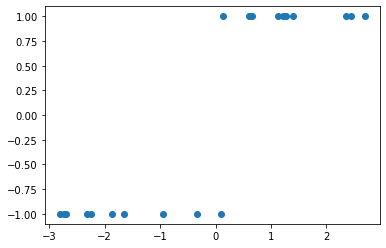

In [56]:
plt.scatter(X, Y);

### Stationary GP model

In [57]:
basic_model = pm.Model()

with basic_model:

    # Priors for unknown model parameters
    # Variance
    kernel_std = pm.Lognormal("kernel_std", 0, 0.1)
    # Length scale
    kernel_ls = pm.Lognormal("kernel_ls", 0, 1)
    noise_sigma = pm.Lognormal("noise_sigma", 0, 1)
    K = kernel(X, X, kernel_ls, kernel_std) 
    K += np.eye(X.shape[0]) * np.power(noise_sigma, 2)
    
    y = pm.MvNormal("y", mu = 0, cov = K, observed = Y)

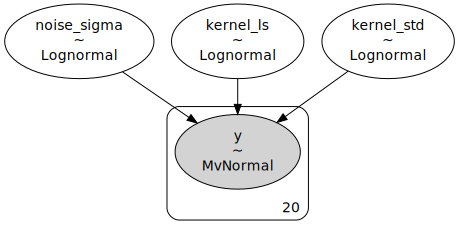

In [58]:
pm.model_to_graphviz(basic_model.model)

In [59]:
map_estimate = pm.find_MAP(model=basic_model)

In [60]:
map_estimate

{'kernel_std_log__': array(-0.02502609),
 'kernel_ls_log__': array(-0.12448224),
 'noise_sigma_log__': array(-0.95456483),
 'kernel_std': array(0.97528447),
 'kernel_ls': array(0.88295395),
 'noise_sigma': array(0.38497964)}

In [61]:
with basic_model:
    # draw 2000 posterior samples per chain
    trace = pm.sample(2000,return_inferencedata=False,tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [noise_sigma, kernel_ls, kernel_std]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 42 seconds.


/home/patel_zeel/anaconda3/lib/python3.8/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


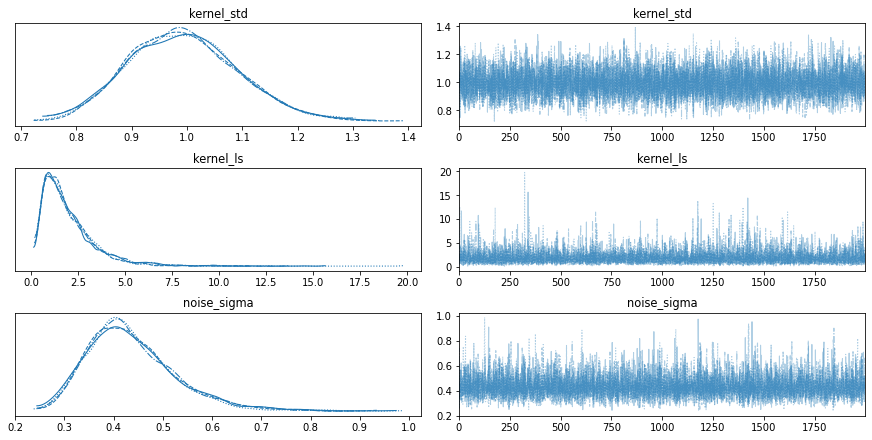

In [63]:
import arviz as az

az.plot_trace(trace);

In [64]:
test_x = np.linspace(-3, 3, 100).reshape(-1, 1)
train_x = X
train_y = Y

def post(train_x, train_y, test_x, kernel, kernel_ls, kernel_std, noise):
    N = len(train_x)
    K = kernel(train_x, train_x, kernel_ls, kernel_std)+noise**2*np.eye(len(train_x))
    N_star = len(test_x)
    K_star = kernel(train_x,  test_x, kernel_ls, kernel_std)
    K_star_star = kernel(test_x, test_x, kernel_ls, kernel_std)
    posterior_mu = K_star.T@np.linalg.inv(K)@(train_y)
    posterior_sigma = K_star_star - K_star.T@np.linalg.inv(K)@K_star
    
    
    # Instead of size = 1, we can also sample multiple times given a single length scale, kernel_std and noise
    return np.random.multivariate_normal(posterior_mu, posterior_sigma, size=1)

In [65]:
# Make predictions at new locations.
train_y = Y
n_samples = 500
preds = np.stack([post(train_x, train_y, test_x=test_x, kernel=kernel, kernel_ls=trace['kernel_ls'][b],
                             kernel_std=trace['kernel_std'][b],
                             noise=trace['noise_sigma'][b])
                  for b in range(n_samples)])

preds.shape

(500, 1, 100)

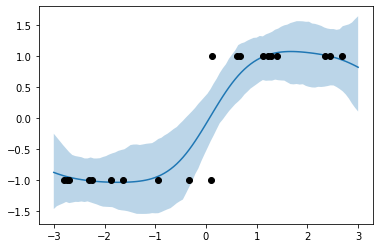

In [66]:
ci = 95
ci_lower = (100 - ci) / 2
ci_upper = (100 + ci) / 2
preds_mean = preds.reshape(n_samples, len(test_x)).mean(0)
preds_lower = np.percentile(preds, ci_lower, axis=0)
preds_upper = np.percentile(preds, ci_upper, axis=0)

plt.plot(test_x,preds.reshape(n_samples, len(test_x)).mean(axis=0))

plt.scatter(train_x, train_y, c='black', zorder=3, label='data')
plt.fill_between(test_x.flatten(), preds_upper.flatten(), preds_lower.flatten(), alpha=.3, label='95% CI');

### LLS GP

In [163]:
n_local = 3
lls_model = pm.Model()
param_X = KMeans(n_local).fit(X).cluster_centers_

with lls_model:
    
    ### Local GP
    # local lengthscale
    local_ls = pm.Lognormal("local_ls", 0, 1)
    param_ls = pm.Lognormal("param_ls", 0, 1, shape=(n_local, 1))
    local_K = local_kernel(param_X, param_X, local_ls)
    local_K_star = local_kernel(X, param_X, local_ls)
    
    ### global GP
    # global lengthscales
    global_ls = pm.math.exp(pm.math.matrix_dot(local_K_star, pm.math.matrix_inverse(local_K), pm.math.log(param_ls)))
    # global variance
    global_std = pm.Lognormal("global_std", 0, 1)
    # global noise
    global_noise_sigma = pm.Lognormal("global_noise_sigma", 0, 1)
    
    global_K = global_kernel(X, X, global_ls, global_ls, global_std)
    global_K += np.eye(X.shape[0])*global_noise_sigma**2
    
    y = pm.MvNormal("y", mu = 0, cov = global_K, observed = Y)

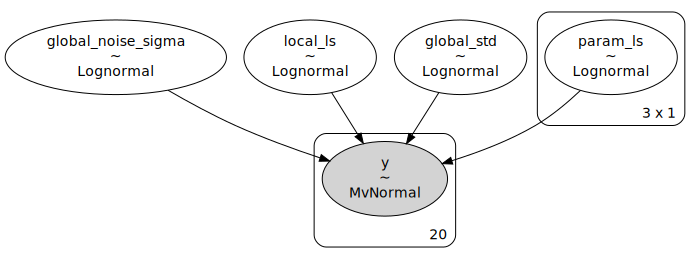

In [164]:
pm.model_to_graphviz(lls_model.model)

In [165]:
map_estimate = pm.find_MAP(model=lls_model)

In [166]:
map_estimate

{'local_ls_log__': array(-1.07661859),
 'param_ls_log__': array([[-0.04218687],
        [ 0.2382263 ],
        [-0.35624966]]),
 'global_std_log__': array(-0.32103389),
 'global_noise_sigma_log__': array(-0.967206),
 'local_ls': array(0.34074578),
 'param_ls': array([[0.95869061],
        [1.26899634],
        [0.70029776]]),
 'global_std': array(0.72539867),
 'global_noise_sigma': array(0.38014368)}

In [167]:
with lls_model:
    # draw 2000 posterior samples per chain
    trace = pm.sample(2000,return_inferencedata=False,tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [global_noise_sigma, global_std, param_ls, local_ls]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 110 seconds.
There were 25 divergences after tuning. Increase `target_accept` or reparameterize.
There were 13 divergences after tuning. Increase `target_accept` or reparameterize.
There were 14 divergences after tuning. Increase `target_accept` or reparameterize.
There were 27 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.


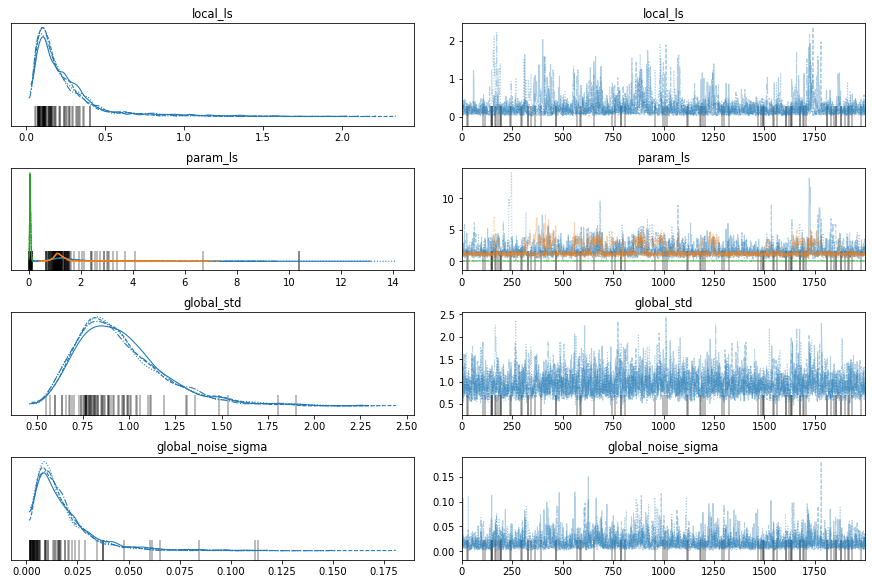

In [168]:
import arviz as az
with lls_model:
    az.plot_trace(trace);

In [169]:
test_x = np.linspace(-3, 3, 100).reshape(-1, 1)
train_x = X
train_y = Y

def post(local_ls, param_ls, global_std, global_noise):
    N = len(train_x)
    param_K_inv = np.linalg.inv(local_kernel(param_X, param_X, local_ls))
    local_K = local_kernel(train_x, param_X, local_ls)
    global_ls = np.exp(local_K@param_K_inv@param_ls)
    local_K_star = local_kernel(test_x, param_X, local_ls)
    global_ls_star = np.exp(local_K_star@param_K_inv@param_ls)
#     print(global_noise)
    K = global_kernel(train_x, train_x, global_ls, global_ls, global_std)+np.eye(N)*global_noise**2
    K_inv = pm.math.matrix_inverse(K)
    K_star = global_kernel(train_x, test_x, global_ls, global_ls_star, global_std)
    posterior_mu = pm.math.matrix_dot(K_star.T,K_inv,train_y)
#     K_star_star = global_kernel(test_x, test_x, global_ls_star, global_ls_star, global_std)
#     posterior_sigma = K_star_star - pm.math.matrix_dot(K_star.T,K_inv,K_star)
    
    return posterior_mu.eval()
    # Instead of size = 1, we can also sample multiple times given a single length scale, kernel_std and noise
    return np.random.multivariate_normal(posterior_mu.eval(), posterior_sigma.eval(), size=1)

In [173]:
# Make predictions at new locations.
n_samples = 70

preds = np.stack([post(local_ls=trace['local_ls'][b],
                       param_ls=trace['param_ls'][b],
                       global_std=trace['global_std'][b],
                      global_noise=trace['global_noise_sigma'][b])
                  for b in range(n_samples)])

preds.shape

(70, 100)

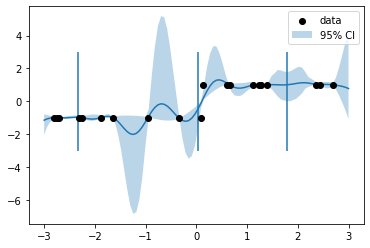

In [174]:
ci = 95
ci_lower = (100 - ci) / 2
ci_upper = (100 + ci) / 2
preds_mean = preds.reshape(n_samples, len(test_x)).mean(0)
preds_lower = np.percentile(preds, ci_lower, axis=0)
preds_upper = np.percentile(preds, ci_upper, axis=0)

plt.plot(test_x,preds.reshape(n_samples, len(test_x)).mean(axis=0))

plt.scatter(train_x, train_y, c='black', zorder=3, label='data')
plt.fill_between(test_x.flatten(), preds_upper.flatten(), preds_lower.flatten(), alpha=.3, label='95% CI');
for x_loc in param_X:
    plt.vlines(x_loc, -3, 3);
plt.legend();